In [34]:
import numpy as np
import pandas as pd
import jax
import jax.numpy as jnp
import optax

from jax import random

key = random.PRNGKey(0)

import matplotlib.pyplot as plt

In [2]:
from src.pyWBM import (
    construct_Kpet_crop,
    pywbm_jax,
)

In [3]:
# Read McLean County input data
PHI = 40.617
tas = np.loadtxt("./data/mclean_county_daily_tas_degC_2016-2022.csv")
prcp = np.loadtxt("./data/mclean_county_daily_prcp_mm_2016-2022.csv")
lai = np.loadtxt("./data/mclean_county_daily_lai_climatology.csv")

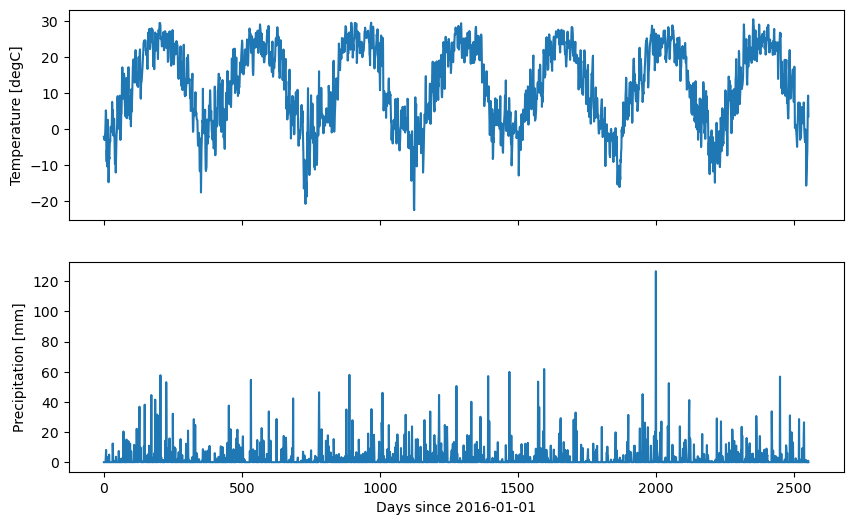

In [4]:
# Plot
fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

axs[0].plot(tas)
axs[0].set_ylabel("Temperature [degC]")

axs[1].plot(prcp)
axs[1].set_ylabel("Precipitation [mm]")

axs[1].set_xlabel("Days since 2016-01-01")
plt.show()

### Running pyWBM for a single gridpoint

In [5]:
## Define some parameters for simulation
# pyWBM parameters
Ts = -1.0
Tm = 1.0
awCap = 300.0
wiltingp = 120.0
rootDepth = 1.0
alpha = 5.5
betaHBV = 3.4

# Crop coefficient timeseries
GS_start = 91  # April 1st
GS_end = 274  # October 1st
L_ini = 0.17
L_dev = 0.28
L_mid = 0.33
L_late = 1.0 - L_ini - L_dev - L_mid
Kc_ini = 0.3
Kc_mid = 1.2
Kc_end = 0.4
Kmin = 0.3
Kmax = 1.2
c_lai = 0.7

Kpet = construct_Kpet_crop(
    GS_start, GS_end, L_ini, L_dev, L_mid, L_late, Kc_ini, Kc_mid, Kc_end, Kmin, Kmax, c_lai, lai
)

# Construct input dicts
theta_true = {"awCap": awCap, "wiltingp": wiltingp, "alpha": alpha, "betaHBV": betaHBV}
constants = {"Ts": -1.0, "Tm": 1.0, "rootDepth": 1.0, "phi": PHI}
params = {**theta_true, **constants}

forcing = {
    "tas": tas,
    "prcp": prcp,
    "Kpet": Kpet,
    "lai": lai,
}

init = {
    "Ws_init": 250.0,
    "Wi_init": 0.0,
    "Sp_init": 0.0,
}

In [6]:
# Simulate soil moisture
soilM_baseline = pywbm_jax(
    forcing=forcing,
    init=init,
    params=params,
)

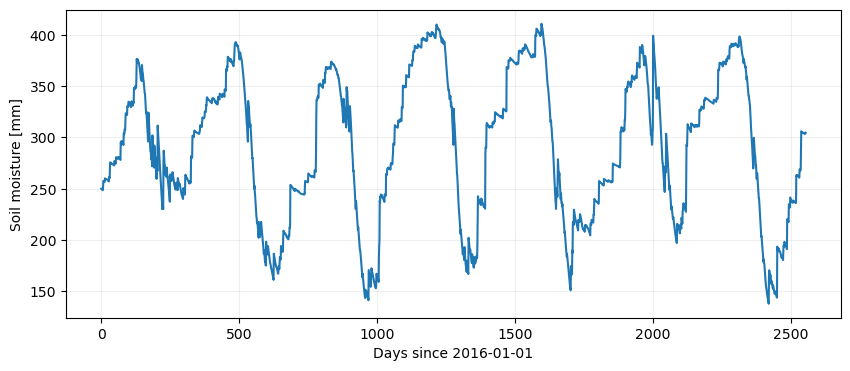

In [7]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(soilM_baseline)
ax.set_ylabel("Soil moisture [mm]")
ax.set_xlabel("Days since 2016-01-01")
ax.grid(alpha=0.2)
plt.show()

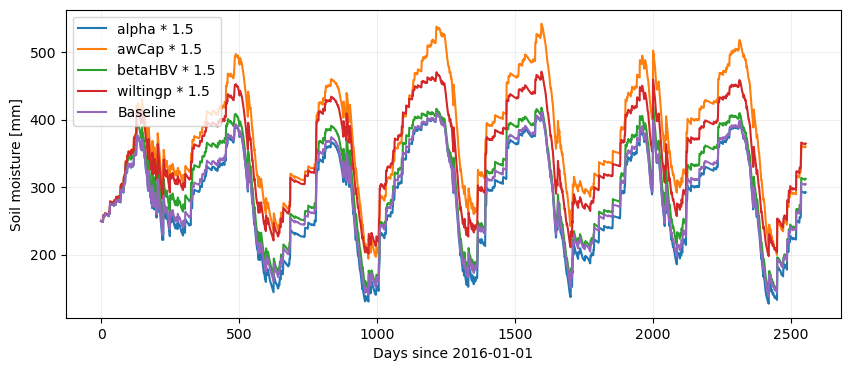

In [8]:
# Change each parameter and plot new soil moisture
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

for param in ["alpha", "awCap", "betaHBV", "wiltingp"]:
    params_plot = params.copy()
    params_plot[param] *= 1.5
    soilM_perturbed = pywbm_jax(params=params_plot, forcing=forcing, init=init)
    ax.plot(soilM_perturbed, label=f"{param} * 1.5")

ax.plot(soilM_baseline, label="Baseline")
ax.set_ylabel("Soil moisture [mm]")
ax.set_xlabel("Days since 2016-01-01")
ax.grid(alpha=0.2)
ax.legend()
plt.show()

### Taking deriviatives

In [9]:
# We need to define a scalar-valued function to differentiate.
# Here we just use the mean of the soil moisture timeseries, but this
# could instead be the max/min, std, etc, or a speficic time index.


def soilM_summary(params, forcing, init):
    summary_func = jnp.max  # could be jnp.max, jnp.min, jnp.std, etc
    return summary_func(pywbm_jax(forcing=forcing, init=init, params=params))

In [10]:
# Calculate the partial derivatives of the summary function with respect to the parameters.
# This tell us how much the output (ie summary function of soil moisture timeseries)
# changes when we change each parameter by an infitesimal amount.
# Can be thought of as a local sensitivity analysis.
jax.grad(soilM_summary)(params, forcing, init)

{'Tm': Array(0., dtype=float32, weak_type=True),
 'Ts': Array(0., dtype=float32, weak_type=True),
 'alpha': Array(-0.13533755, dtype=float32, weak_type=True),
 'awCap': Array(0.9143404, dtype=float32),
 'betaHBV': Array(6.5233316, dtype=float32, weak_type=True),
 'phi': Array(nan, dtype=float32, weak_type=True),
 'rootDepth': Array(394.30212, dtype=float32),
 'wiltingp': Array(1., dtype=float32)}

In [11]:
# We can check against a finite differences approximation
eps = 1e-3

param_to_check = "betaHBV"

grad_auto = jax.grad(soilM_summary)(params, forcing, init)[param_to_check]

grad_numerical = (
    soilM_summary(
        dict(params, **{param_to_check: params[param_to_check] + eps / 2.0}), forcing, init
    )
    - soilM_summary(
        dict(params, **{param_to_check: params[param_to_check] - eps / 2.0}), forcing, init
    )
) / eps

print("grad_auto", grad_auto)
print("grad_numerical", grad_numerical)

grad_auto 6.5233316
grad_numerical 6.5307612


### Using derivatives to fit parameters

In [59]:
## Let's see if we can recover the "true" (i.e. baseline) parameters using gradient descent

# Define a loss metric: RMSE
def _rmse(prediction, ys):
    return jnp.sqrt(jnp.mean((prediction - ys) ** 2))


# Define loss function
def loss(theta, constants, forcing, init, ys):
    prediction = pywbm_jax({**theta, **constants}, forcing, init)
    return _rmse(prediction, ys)


# Choose an optimizer
def initialize_optimizer(opt_name, learning_rate, theta):
    if opt_name == "adam":
        adam = optax.adam(learning_rate=learning_rate)
        opt_fn = adam.update
        opt_state = adam.init(theta)
    elif opt_name == "sgd":
        opt_state = None

        def sgd(gradients, state):
            return {k: v - learning_rate * gradients for k, v in theta.items()}, state

        opt_fn = sgd

    return opt_fn, opt_state


# Define an update function
# We use the standard notation of xs for (multi-dimensional) input data,
# ys for output data, and theta for the parameters to be updated.
@jax.jit
def update(theta, constants, forcing, init, ys, opt_state):
    # Gradient calculation
    # Note jax.grad differentiates with respect to the first argument by default, but
    # this can be changed with the `argnums` argument.
    loss_grad = jax.grad(loss)

    # Update
    gradients = loss_grad(theta, constants, forcing, init, ys)
    updates, opt_state = opt_fn(gradients, opt_state)
    theta = optax.apply_updates(theta, updates)
    return theta

In [60]:
## Run the calibration

# Starting values
theta_init = {"awCap": 300.0, "wiltingp": 90.0, "alpha": 5.0, "betaHBV": 2.0}
theta = theta_init.copy()

# Optimizer initialization
opt_fn, opt_state = initialize_optimizer("adam", 0.02, theta)

# Training loop
for i in range(1001):
    theta = update(theta, constants, forcing, init, soilM_baseline, opt_state)

    if i % 100 == 0:
        print(
            f"Step {i}, RMSE: {_rmse(pywbm_jax({**theta, **constants}, forcing, init), soilM_baseline)}"
        )

Step 0, RMSE: 28.989831924438477
Step 100, RMSE: 25.966028213500977
Step 200, RMSE: 22.949020385742188
Step 300, RMSE: 19.94158172607422
Step 400, RMSE: 16.948450088500977
Step 500, RMSE: 13.978391647338867
Step 600, RMSE: 11.049396514892578
Step 700, RMSE: 8.204740524291992
Step 800, RMSE: 5.573771953582764
Step 900, RMSE: 3.6498000621795654
Step 1000, RMSE: 3.0489494800567627


In [36]:
# How close did we get?
data = {
    "True": [theta_true[param] for param in theta],
    "Estimated": [theta[param] for param in theta],
}
df = pd.DataFrame(data, index=theta.keys())
df["Pct diff"] = (df["Estimated"] - df["True"]) / df["True"] * 100
print(df)

           True  Estimated    Pct diff
alpha       5.5   4.499998  -18.181852
awCap     300.0  313.57254     4.52418
betaHBV     3.4  3.6199985     6.47054
wiltingp  120.0  103.65771  -13.618578


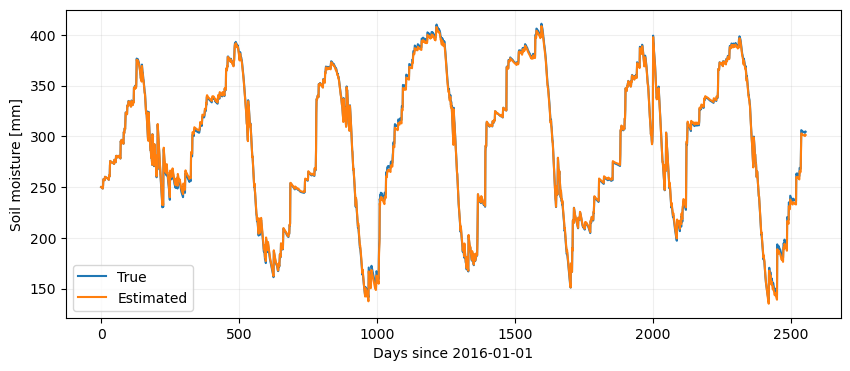

In [37]:
# Plot timeseries
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

# Plot timeseries of true and estimated soil moisture
ax.plot(soilM_baseline, label="True")
ax.plot(pywbm_jax({**theta, **constants}, forcing, init), label="Estimated")
ax.set_ylabel("Soil moisture [mm]")
ax.set_xlabel("Days since 2016-01-01")
ax.grid(alpha=0.2)
ax.legend()
plt.show()

You can see that we are able to reproduce the timeseries extremely closely, even if the parameter values themselves are up to ~18% off. Since the RMSE was not decreasing in the later iterations of the training loop, we are likely in a local minimum and would require a more sophisticated optimization algorithm to find the global minimum. Alternatively, you could play around with the starting parameter values, optimization approach (including the learning rate), or loss metric to try to recover the true parameter values.

### Expanding the number of uncertain parameters

In the above example, we used the native `pyywbm_jax` function which accepts tuples representing the forcing, initial values, and parameters. We only calibrated a subset of parameters within the parameter dict. In general we may also want to calibrate the initial values or the some of the forcing inputs (e.g. the crop coefficient timeseries). We can do this by writing a wrapper function that re-organizes the tuple inputs. The reason for this is that ultimately, we need to define a loss function that is differentiable with respect to a set of inputs that we are trying to update. The `pywbm_example_wrapper` function below could be changed to add or remove parameters from the optimization process.

In [61]:
# Assume we want to calibrate the crop coefficient timeseries and initialalization values, as well as
# some soil parameters. We can do this by defining a new loss function that depends on all of these
# uncertain inputs.
@jax.jit
def pywbm_example_wrapper(theta, constants, forcing_known):
    # We continue to use `theta` nomenclature for uncertain parameters.
    # Extract everything here for clarity. These represent all the uncertain
    # inputs that we want to calibrate.
    awCap = theta["awCap"]
    wiltingp = theta["wiltingp"]
    GS_start = theta["GS_start"]
    GS_end = theta["GS_end"]
    Kmin = theta["Kmin"]
    Kmax = theta["Kmax"]
    c_lai = theta["c_lai"]
    Ws_init = theta["Ws_init"]

    # Other parameters that are held constant
    Ts = constants["Ts"]
    Tm = constants["Tm"]
    rootDepth = constants["rootDepth"]
    phi = constants["phi"]
    alpha = constants["alpha"]
    betaHBV = constants["betaHBV"]
    L_ini = constants["L_ini"]
    L_dev = constants["L_dev"]
    L_mid = constants["L_mid"]
    L_late = 1.0 - L_ini - L_dev - L_mid
    Kc_ini = constants["Kc_ini"]
    Kc_mid = constants["Kc_mid"]
    Kc_end = constants["Kc_end"]

    Kpet = construct_Kpet_crop(
        GS_start,
        GS_end,
        L_ini,
        L_dev,
        L_mid,
        L_late,
        Kc_ini,
        Kc_mid,
        Kc_end,
        Kmin,
        Kmax,
        c_lai,
        lai,
    )

    # Now we construct the `pywbm_jax` input dicts as normal.
    params = {
        "Ts": Ts,
        "Tm": Tm,
        "awCap": awCap,
        "wiltingp": wiltingp,
        "rootDepth": rootDepth,
        "phi": phi,
        "alpha": alpha,
        "betaHBV": betaHBV,
    }

    forcing = {
        "tas": forcing_known["tas"],
        "prcp": forcing_known["pr"],
        "Kpet": Kpet,
        "lai": forcing_known["lai"],
    }

    init = {
        "Ws_init": Ws_init,
        "Wi_init": 0.0,
        "Sp_init": 0.0,
    }

    # Run it
    soilM = pywbm_jax(
        forcing=forcing,
        init=init,
        params=params,
    )

    return soilM


# Finally, we can define a new (but similar) loss and update function. This is similar to before
# but accounts for the new structure of the wrapper function.
def loss(theta, constants, forcing_known, ys):
    prediction = pywbm_example_wrapper(theta, constants, forcing_known)
    return _rmse(prediction, ys)


@jax.jit
def update(theta, constants, forcing_known, ys, opt_state):
    # Gradient calculation
    # Note jax.grad differentiates with respect to the first argument by default, but
    # this can be changed with the `argnums` argument.
    loss_grad = jax.grad(loss)

    # Update
    gradients = loss_grad(theta, constants, forcing_known, ys)
    updates, opt_state = opt_fn(gradients, opt_state)
    theta = optax.apply_updates(theta, updates)
    return theta

In [68]:
## Run the calibration. Note the update step is identical to before.

# Starting values
theta_init = {
    "awCap": 300.0,
    "wiltingp": 90.0,
    "GS_start": 100.0,
    "GS_end": 250.0,
    "Kmin": 0.2,
    "Kmax": 1.5,
    "c_lai": 0.5,
    "Ws_init": 200.0,
}
theta = theta_init.copy()

# New constants dict with correct parameter values
constants = {
    "Ts": -1.0,
    "Tm": 1.0,
    "rootDepth": 1.0,
    "phi": PHI,
    "alpha": alpha,
    "betaHBV": betaHBV,
    "L_ini": L_ini,
    "L_dev": L_dev,
    "L_mid": L_mid,
    "Kc_ini": Kc_ini,
    "Kc_mid": Kc_mid,
    "Kc_end": Kc_end,
}

# 'Known' forcing dict
forcing_known = {
    "tas": tas,
    "pr": prcp,
    "lai": lai,
}

# Optimizer initialization
opt_fn, opt_state = initialize_optimizer("adam", 0.02, theta)

# Training loop
for i in range(5001):
    theta = update(theta, constants, forcing_known, soilM_baseline, opt_state)

    if i % 500 == 0:
        print(
            f"Step {i}, RMSE: {_rmse(pywbm_example_wrapper(theta, constants, forcing_known), soilM_baseline)}"
        )

Step 0, RMSE: 27.389787673950195
Step 500, RMSE: 8.983874320983887
Step 1000, RMSE: 7.6309967041015625
Step 1500, RMSE: 6.5815582275390625
Step 2000, RMSE: 6.138205051422119
Step 2500, RMSE: 6.112132549285889
Step 3000, RMSE: 6.112132549285889
Step 3500, RMSE: 6.112132549285889
Step 4000, RMSE: 6.112132549285889
Step 4500, RMSE: 6.112132549285889
Step 5000, RMSE: 6.112132549285889


In [69]:
# How close did we get this time?
theta_true_example = {
    "awCap": awCap,
    "wiltingp": wiltingp,
    "GS_start": GS_start,
    "GS_end": GS_end,
    "Kmin": Kmin,
    "Kmax": Kmax,
    "c_lai": c_lai,
    "Ws_init": 250.0,
}

data = {
    "True": [theta_true_example[param] for param in theta],
    "Estimated": [theta[param] for param in theta],
}
df = pd.DataFrame(data, index=theta.keys())
df["Pct diff"] = (df["Estimated"] - df["True"]) / df["True"] * 100
print(df)

           True     Estimated    Pct diff
GS_end    274.0     255.26112  -6.8390055
GS_start   91.0    108.658424   19.404861
Kmax        1.2     1.1600024  -3.3331413
Kmin        0.3  -0.019998385  -106.66612
Ws_init   250.0     242.94917  -2.8203309
awCap     300.0     309.41483   3.1382751
c_lai       0.7     0.8799974   25.713911
wiltingp  120.0     100.37826  -16.351452


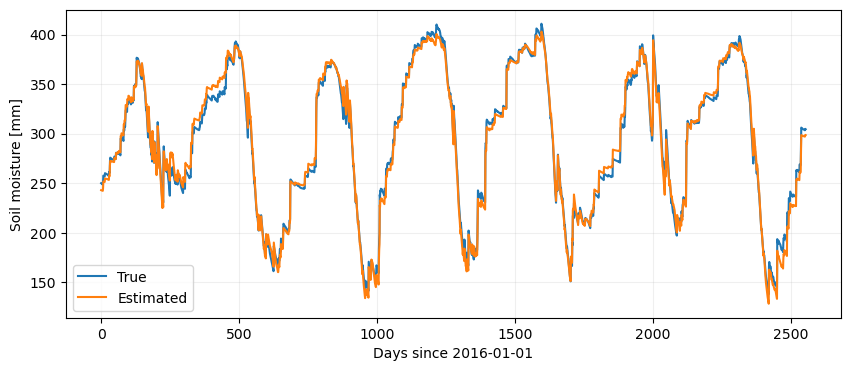

In [70]:
# Plot timeseries
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

# Plot timeseries of true and estimated soil moisture
ax.plot(soilM_baseline, label="True")
ax.plot(pywbm_example_wrapper(theta, constants, forcing_known), label="Estimated")
ax.set_ylabel("Soil moisture [mm]")
ax.set_xlabel("Days since 2016-01-01")
ax.grid(alpha=0.2)
ax.legend()
plt.show()